In [1]:
# %matplotlib qt
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
import numpy as np
import numpy.linalg as npl
from matplotlib import pyplot as plt
from matplotlib import cbook
import ipywidgets as widgets
import time
import timeit

In [3]:
from helpers import *

In [4]:
EXAMPLE_DIR = 'church'
DEPTH_RES = 128
ON_SURFACE = True

In [5]:
image = cv2.imread(f'./data/{EXAMPLE_DIR}/input.png')
depth = cv2.imread(f'./data/{EXAMPLE_DIR}/depth_metric_r20.png', cv2.IMREAD_ANYDEPTH)
normals = cv2.imread(f'./data/{EXAMPLE_DIR}/normals.png')
shading = cv2.imread(f'./data/{EXAMPLE_DIR}/ours_shd.png')
albedo = cv2.imread(f'./data/{EXAMPLE_DIR}/ours_alb.png')

# Preprocessing
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image / np.max(image)

depth = np.array(depth / np.max(depth) * DEPTH_RES, dtype='uint8')
depth = DEPTH_RES - depth

# normals = cv2.cvtColor(normals, cv2.COLOR_BGR2RGB)
normals = ((normals / np.max(normals)) * 2) - 1

albedo = cv2.cvtColor(albedo, cv2.COLOR_BGR2RGB)
albedo = albedo / np.max(albedo)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0.98, 'Mid Level Decomposition for church')

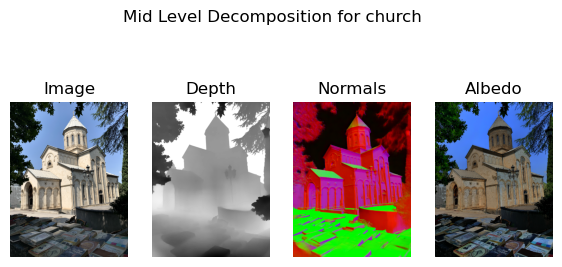

In [6]:
fig, ax = plt.subplot_mosaic([['image', 'depth', 'normals', 'albedo']], figsize=(7, 3.5))
ax['image'].imshow(image)
ax['image'].axis('off')
ax['image'].set_title('Image')

ax['depth'].imshow(depth, cmap='gray')
ax['depth'].axis('off')
ax['depth'].set_title('Depth')

ax['normals'].imshow(normals)
ax['normals'].axis('off')
ax['normals'].set_title('Normals')

ax['albedo'].imshow(albedo)
ax['albedo'].axis('off')
ax['albedo'].set_title('Albedo')

fig.suptitle(f'Mid Level Decomposition for {EXAMPLE_DIR}')

## The following block handles all computation
It could be optimized by altering unit_direction_3D to only calculate direction and magnitude on the surface, rather than at every points throughout the meshgrid

In [16]:
light_origin = np.array([500, 250, 120])

# Hardcoded shortcut to place light just on top of surface
if ON_SURFACE:
    light_origin[2] = depth[light_origin[0], light_origin[1]] - 16
t0 = time.perf_counter()
xx, yy, zz = create_meshgrid(depth, z_axis_resolution=DEPTH_RES)
t1 = time.perf_counter()
print(f"Meshgrid created in {t1-t0} seconds")

t0 = time.perf_counter()
light_vector_field, light_magnitude_field = unit_direction_3d(light_origin[0], light_origin[1], light_origin[2], xx, yy, zz)
t1 = time.perf_counter()
print(f"Vector field and Magnitude field created in {t1-t0} seconds")

t0 = time.perf_counter()
surface_lighting = get_surface_lighting(image, depth, light_vector_field, light_magnitude_field, spotlight_radius=0)
t1 = time.perf_counter()
print(f"Surface lighting extracted in {t1-t0} seconds")

t0 = time.perf_counter()
relit_image = apply_surface_lighting(surface_lighting, light_magnitude_field, normals, albedo, light_colour=[1, 0, 0.82])
t1 = time.perf_counter()
print(f"Image relighting applied in {t1-t0} seconds")

print(f"{np.min(relit_image)= }, {np.max(relit_image)= }")
print(f'{np.min(normals)= }, {np.max(normals)= }, {np.min(surface_lighting)= }, {np.max(surface_lighting)= }, {np.min(albedo)= }, {np.max(albedo)= }')

Meshgrid created in 0.0012068329997418914 seconds
Time to calculate magnitudes = 0.8978202050002437
Time to stack direction vectors = 3.147488405999866
Time to make direction vectors unit length = 1.9700513009993301
Vector field and Magnitude field created in 6.0406089019998035 seconds
Surface lighting extracted in 12.646912265000537 seconds
Image relighting applied in 0.06342097699962324 seconds
np.min(relit_image)= -1.39429374847851, np.max(relit_image)= 1.7250433638395044
np.min(normals)= -1.0, np.max(normals)= 1.0, np.min(surface_lighting)= -1.016084070464109, np.max(surface_lighting)= 1.047613811999469, np.min(albedo)= 0.0, np.max(albedo)= 1.0


# This block plots

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0.98, 'Mid Level Decomposition for church')

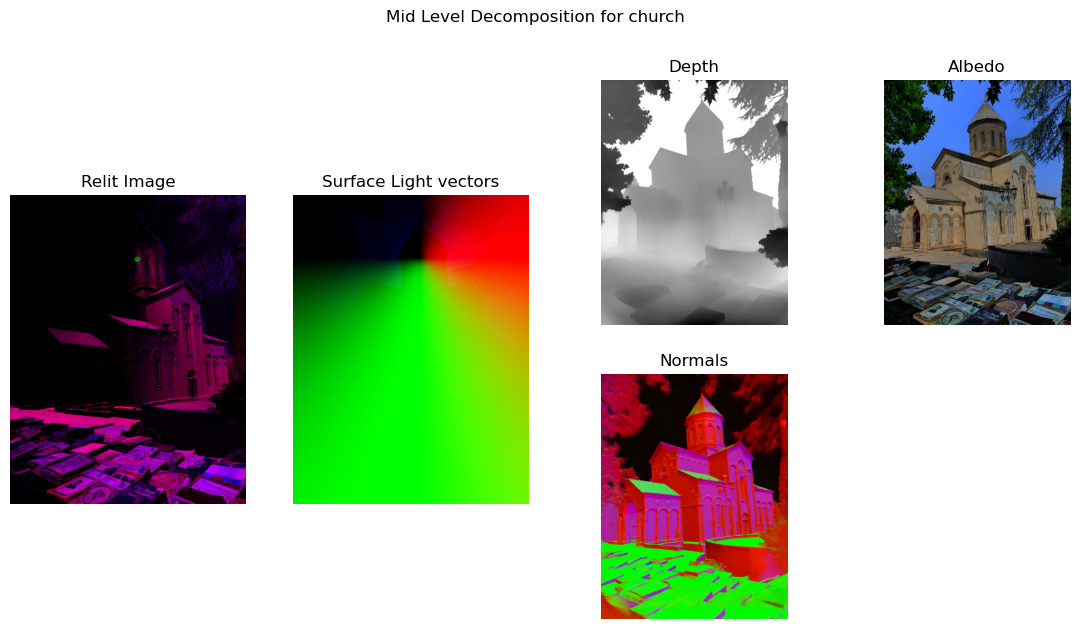

In [17]:
fig, ax = plt.subplot_mosaic([['relit_image', 'light_vectors', 'depth', 'albedo'],
                              ['relit_image', 'light_vectors', 'normals', '.']], figsize=(14, 7))
ax['relit_image'].imshow(relit_image)
ax['relit_image'].axis('off')
ax['relit_image'].set_title('Relit Image')
ax['relit_image'].plot(light_origin[0], light_origin[1], "og", markersize=3)

ax['light_vectors'].imshow(surface_lighting)
ax['light_vectors'].axis('off')
ax['light_vectors'].set_title('Surface Light vectors')

ax['depth'].imshow(depth, cmap='gray')
ax['depth'].axis('off')
ax['depth'].set_title('Depth')

ax['normals'].imshow(normals)
ax['normals'].axis('off')
ax['normals'].set_title('Normals')

ax['albedo'].imshow(albedo)
ax['albedo'].axis('off')
ax['albedo'].set_title('Albedo')

fig.suptitle(f'Mid Level Decomposition for {EXAMPLE_DIR}')

## Set up widget interface
TODO!

In [ ]:
y_slider = widgets.FloatSlider(
    value=0.5,
    min=0,
    max=1.0,
    step=0.01,
    description='Y Coordinate',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.01f',
)

x_slider = widgets.FloatSlider(
    value=0.5,
    min=0,
    max=1.0,
    step=0.01,
    description='X Coordinate',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.01f',
)

z_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=DEPTH_RES,
    step=1,
    description='Z Coordinate',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
)

In [ ]:
file = open(f'./data/{EXAMPLE_DIR}/input.png', "rb")
img = file.read()
img_widget = widgets.Image(
    value=img,
    format='png',
    width=300,
    height=400,
)

In [ ]:
grid = widgets.GridspecLayout(7, 1, height='700px')
grid[:4, :] = img_widget
grid[4, :] = x_slider
grid[5, :] = y_slider
grid[6, :] = z_slider
grid

In [ ]:
widgets.ColorPicker(
    concise=False,
    description='Pick a color',
    value='blue',
    disabled=False
)